In [ ]:
# importing neccessary Packages
import pickle
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from time import gmtime, strftime
import matplotlib.pyplot as plt

import os, sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 7)
pd.set_option('display.max_columns', None)

sns.set_style("darkgrid")
%matplotlib inline

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from log import get_logger

file_handler = FileHandler() 
my_logger = get_logger("model_prediction")

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv("../data/cleaned_train.csv")
test_data = pd.read_csv("../data/cleaned_test.csv")
#tain_store_data = pd.read_csv("../data/clean_train_store.csv")

#### Preprocessing 
 * label Encoding Date column

In [5]:
try:
    # Train with only by the opened stores and Sales greater than zero.
    
    train_data = train_data[train_data['Open'] == 1]
    train_data = train_data[train_data['Sales'] > 0.0]

    # Label encode Date in both training and testing datasets
    for dataset in (train_data, test_data):
        encoder = preprocessing.LabelEncoder()
        dataset['Date'] = encoder.fit_transform(dataset['Date'])

    my_logger.debug("Date is encoded successfully.")
            
except Exception as e:
    my_logger.exception(f'Exception occured in Date encoding!, {e}')

2022-09-10 13:03:34,965 — model_prediction — DEBUG — Date is encoded successfully.


#### Feature Engineering
* Normalization

In [6]:
#normalizating using minmax scaler techeniques
scaler = MinMaxScaler()

trainining_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',\
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',\
                    'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

testing_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment',\
                  'CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', \
                  'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

temp_train_data = train_data.copy()
temp_test_data = test_data.copy()   

try:
    for i in trainining_columns:
    
        # fit on training data column
        scale = scaler.fit(temp_train_data[[i]])
        
        # transform the training data column
        temp_train_data[i] = scale.transform(temp_train_data[[i]])
    
    for i in testing_columns:
    
        # fit on training data column
        scale = scaler.fit(temp_test_data[[i]])
        
        # transform the training data column
        temp_test_data[i] = scale.transform(temp_test_data[[i]]) 
    
    my_logger.debug("Normalization successfully Done.")
    
except Exception as e:
    my_logger.debug(f"Exception occured while Normalizing the dataset, {e}")

2022-09-10 13:03:56,832 — model_prediction — DEBUG — Normalization successfully Done.


In [7]:
#Decribing the dataset
temp_train_data.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear
count,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000
mean,0.500,0.420,0.494,0.486,0.493,0.000,0.446,0.000,0.194,0.402,0.468,0.288,0.386,0.893,0.499,0.232,0.893,0.269,0.495,0.441,0.416,0.443,0.444
std,0.289,0.287,0.292,0.197,0.203,0.000,0.497,0.016,0.395,0.454,0.497,0.323,0.357,0.087,0.500,0.306,0.087,0.327,0.289,0.302,0.389,0.278,0.282
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.250,0.167,0.241,0.344,0.346,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.000,0.783,0.000,0.000,0.783,0.000,0.233,0.182,0.000,0.203,0.196
50%,0.500,0.333,0.482,0.452,0.452,0.000,0.000,0.000,0.000,0.000,0.000,0.143,0.273,0.922,0.000,0.000,0.922,0.000,0.500,0.455,0.500,0.420,0.431
75%,0.750,0.667,0.753,0.594,0.599,0.000,1.000,0.000,0.000,1.000,1.000,0.426,0.727,0.965,1.000,0.440,0.965,0.333,0.733,0.636,0.500,0.659,0.667
max,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<AxesSubplot:xlabel='Date', ylabel='Sales'>

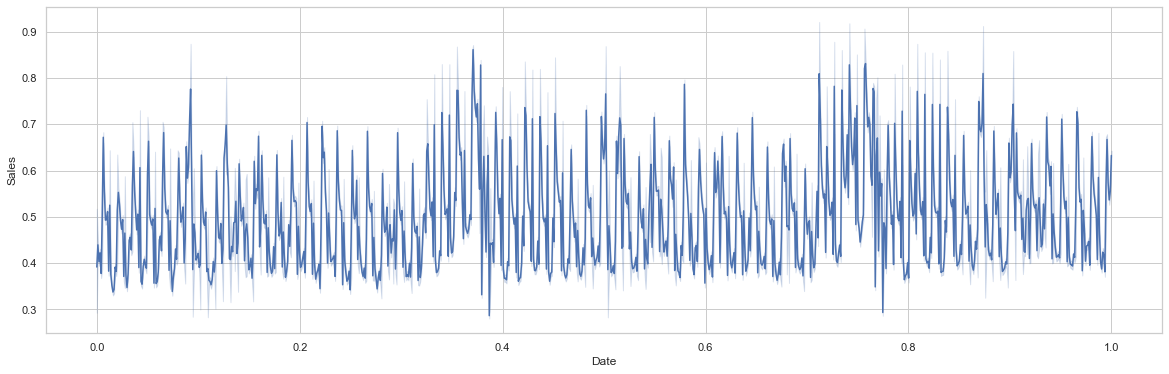

In [8]:
# Using Scaled Units
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x='Date',y='Sales',data=temp_train_data)

##### Spiliting DataSet into Train and Test Dataset

In [9]:
# sample_train = temp_train_data.sample(10000)

y_target = temp_train_data.Sales
x_features =  temp_train_data.drop(columns=['Sales', 'Customers'], axis=1)

In [10]:
# Train-test splitting the dataset

try: 
    x_train, x_train_test, y_train, y_train_test = train_test_split(x_features, y_target, test_size=0.20, random_state=15)
    my_logger.info("Train Test split done successfully.")

except Exception as e:
    print(e)
    my_logger.debug(f"Exception occured in separating dataset into x & y_training dataset, {e}")

2022-09-10 13:09:06,004 — model_prediction — INFO — Train Test split done successfully.


In [11]:
# train size
x_train.shape

(675470, 21)

#### Building models with sklearn pipelines


In [ ]:
def evaluate_models(model_=None, **kwargs):
    """
    - Evaluate our classifiers
    """
    model_name = model_.__name__
    scores = 0.0
    exp_name = "Modeling with "+ model_name
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name = exp_name) as run:
        mlflow.set_tag("mlflow.runName", exp_name)
        model = model_(**kwargs)
        model.fit(x_train,y_train)
        mlflow.sklearn.log_model(model,"Regressor Model")
        my_logger.info(f"fitted a {model} model")
        
        # Then predict results from x_train_test data
        predicted_data = model.predict(x_train_test)
        scores = mean_absolute_error(y_train_test, predicted_data)
        my_logger.info("predicting for a group instance")
        mlflow.log_metric("scores",scores)
        
        # serialize the model
        file_handler.save_model(model, model_name)

    return (scores, predicted_data) 

In [ ]:
# training using cross validation set
regressor_validation=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, 
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
# try:
#     rf_model_test=regressor_validation.fit(x_train,y_train)

# except Exception as e:
#     my_logger(f"Model fitting failed to complete, {e}")

In [ ]:
try:
    RF_prediction = evaluate_models(model_=RandomForestRegressor, n_estimators=10)

except Exception as e:
    my_logger(f"Model fitting failed to complete, {e}")

In [ ]:
mae, predictions = RF_prediction
mae

In [ ]:
try:
    LGBM_prediction = evaluate_models(model_ = LGBMRegressor, n_estimators = 10)

except Exception as e:
    my_logger(f"Model fitting failed to complete, {e}")

In [ ]:
mae, predictions = LGBM_prediction
mae